In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load, dump
from metrics import NWRMSLE, MAE, RMSE
import numpy as np
from tensorflow import keras
import json

2024-05-10 11:00:39.949500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 11:00:40.504609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 11:00:41.945409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open("results/history.pkl", "rb") as f:
    train_history = load(f).history

# Look at the training curves

In [3]:
train_history.keys()

dict_keys(['loss', 'mean_absolute_error', 'r2_score', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_r2_score', 'val_root_mean_squared_error', 'learning_rate'])

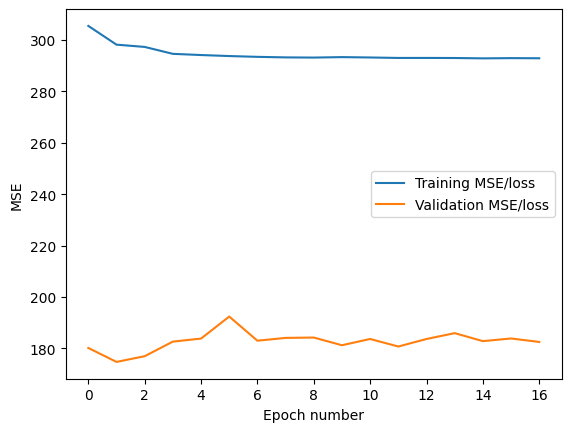

In [4]:
plt.plot(list(range(len(train_history["loss"]))), train_history["loss"], label="Training MSE/loss")
plt.plot(list(range(len(train_history["val_loss"]))), train_history["val_loss"], label="Validation MSE/loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("MSE")
plt.show()
# plt.ylim(0, 20)

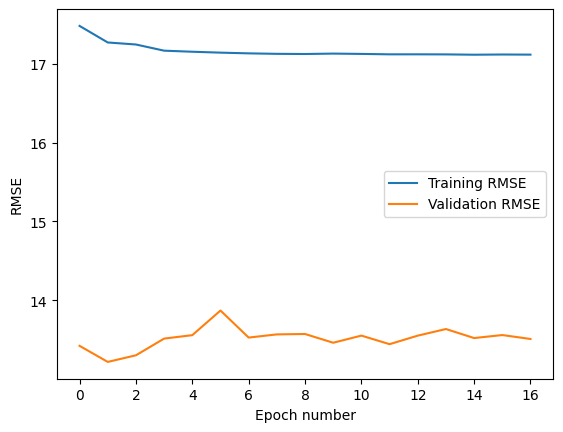

In [5]:
# plotting loss in "real" terms
plt.plot(list(range(len(train_history["root_mean_squared_error"]))), train_history["root_mean_squared_error"], label="Training RMSE")
plt.plot(list(range(len(train_history["val_root_mean_squared_error"]))), train_history["val_root_mean_squared_error"], label="Validation RMSE")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("RMSE")
plt.show()

Looks like... training didn't do much other than making the validation results worse. Potentially not enough data (so not enough compute), potentially that the model doesn't have enough capacity to model this problem well.

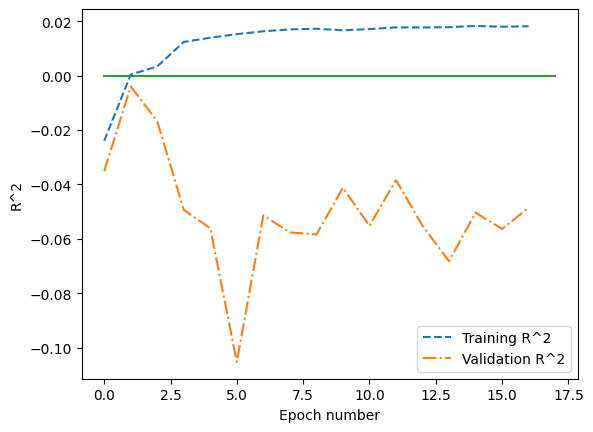

In [6]:
# plotting loss in "real" terms
plt.plot(list(range(len(train_history["r2_score"]))), train_history["r2_score"], label="Training R^2", linestyle="--")
plt.plot(list(range(len(train_history["val_r2_score"]))), train_history["val_r2_score"], label="Validation R^2", linestyle="-.")
plt.plot([0, len(train_history["r2_score"])], [0, 0])
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("R^2")
# plt.ylim(-1-0.01, 1+0.01)
plt.show()

Worrying....

# Look at and compare model results against everything created

In [18]:
def linear_model(data):
    """
    Really janky implementation of the final OLS model created in the EDA notebook (after pruning 
    the variables less statistically significant than MEATS, as a drop off in significance was clear here).
    Assumes variable order of dcoilwtico, day_off, produce, type_A, beverage, poultry, meats
    """
    coeffs = [0.0961, 1.3461, 9.3862, 4.8259, 5.5805, 7.9475, 5.2810]
    preds = []
    for i in range(data.shape[0]):
        row = data[i, -1, :]  # finagle the time-series structure
        preds.append(sum(coeffs[j]*row[j] for j in range(len(coeffs))))
    return preds

In [19]:
def linear_model_2(data):
    """
    Really janky implementation of the final OLS model created in the EDA notebook (after pruning 
    the variables less statistically significant than MEATS, as a drop off in significance was clear here).
    Assumes variable order of onpromotion, produce, type_A, beverage, perishable, poultry, day_off, meats, prepared_foods, school_office_supplies
    """
    coeffs = [9.2895, 9.1068, 6.8386, 8.0795, 2.0434, 8.1769, 3.7500, 5.5691, 6.9025, 5.4077]
    preds = []
    for i in range(data.shape[0]):
        row = data[i, -1, :]  # finagle the time-series structure
        preds.append(sum(coeffs[j]*row[j] for j in range(len(coeffs))))
    return preds

In [11]:
with open("data/ts_test.pkl", "rb") as f:
    test_x, test_y = load(f)

with open("data/ts_test_ols2.pkl", "rb") as f:
    test_x_ols, test_y_ols = load(f)

In [12]:
perishable = test_x_ols[:, 4, -1]
perishable

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Interesting that the test set contains no perishables!

In [13]:
model = keras.models.load_model("checkpoint/LSTM.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7)              │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,373 (5.37 KB)

 Trainable params: 457 (1.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 916 (3.58 KB)

In [14]:
predictions = model.predict(test_x)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [15]:
# duplicating code from baseline_data
def get_data_NWRMSLE(weights):
    def metric(preds, data):
        return NWRMSLE(preds, data, weights)

    return metric


def get_weights(perishable):
    return pd.Series(1.25 if item else 1 for item in perishable)

# messy, but I have verified that the test set does not contian any perishible goods!
test_nwrmsle = get_data_NWRMSLE(get_weights(perishable))

In [16]:
actual, lstm_preds = pd.Series(test_y.flatten()), pd.Series(predictions.flatten())
test_nwrmsle(actual, lstm_preds), MAE(actual, lstm_preds), RMSE(actual, lstm_preds)

(1.068054831746099, 7.8020108086756785, 13.220252066355135)

In [20]:
ols_preds = pd.Series(linear_model(test_x))

In [21]:
test_nwrmsle(actual, ols_preds), MAE(actual, ols_preds), RMSE(actual, ols_preds)

(0.9789151701218116, 7.0798003946312935, 13.562195271378574)

In [22]:
ols_2_preds = pd.Series(linear_model_2(test_x_ols))

In [23]:
test_nwrmsle(actual, ols_2_preds), MAE(actual, ols_2_preds), RMSE(actual, ols_2_preds)

(1.3255975738327113, 7.570075435816165, 14.263762380735068)

In [15]:
with open("results/persist.json") as f:
    persist_res = json.load(f)
persist_res

{'nwrmsle': 0.6846350252610847,
 'mae': 4.558459498115003,
 'mse': 21.87350490230567}

In [16]:
with open("results/mv_av.json") as f:
    mv_av_res = json.load(f)
mv_av_res

{'nwrmsle': 1.9562475266137467,
 'mae': 7.727863143990023,
 'mse': 24.65884468622079}

Note: what's reported as MSE here is actually RMSE

Very interesting results! Observations:
* LSTM learnt a very similarly performing model to the "most significant" OLS model (at least over this test set)
* The most correlated OLS model performs similarly but a bit worse than both
* The persistance model is the most performant according to the NWRMSLE and MAE metrics, but noticably worse on RMSE than OLS and LSTM
    * My guess is when it's wrong, it's **really** wrong, would make sense with the model definition
* The moving average model performs the worst across the board. Adding autoregression may help, but seems unlikely, so using ARMA/ARIMA models on this dataset may not improve results
* Wish I had more time to go through this in more detail!